In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


In [24]:
# Load dataset
df = pd.read_csv("embedded_system_network_security_dataset.csv")

# View data
df.head()


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False


In [25]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   packet_size            1000 non-null   float64
 1   inter_arrival_time     1000 non-null   float64
 2   src_port               1000 non-null   int64  
 3   dst_port               1000 non-null   int64  
 4   packet_count_5s        1000 non-null   float64
 5   mean_packet_size       1000 non-null   float64
 6   spectral_entropy       1000 non-null   float64
 7   frequency_band_energy  1000 non-null   float64
 8   label                  1000 non-null   float64
 9   protocol_type_TCP      1000 non-null   bool   
 10  protocol_type_UDP      1000 non-null   bool   
 11  src_ip_192.168.1.2     1000 non-null   bool   
 12  src_ip_192.168.1.3     1000 non-null   bool   
 13  dst_ip_192.168.1.5     1000 non-null   bool   
 14  dst_ip_192.168.1.6     1000 non-null   bool   
 15  tcp_f

packet_size              0
inter_arrival_time       0
src_port                 0
dst_port                 0
packet_count_5s          0
mean_packet_size         0
spectral_entropy         0
frequency_band_energy    0
label                    0
protocol_type_TCP        0
protocol_type_UDP        0
src_ip_192.168.1.2       0
src_ip_192.168.1.3       0
dst_ip_192.168.1.5       0
dst_ip_192.168.1.6       0
tcp_flags_FIN            0
tcp_flags_SYN            0
tcp_flags_SYN-ACK        0
dtype: int64

In [ ]:
# Select numeric features only
features = df.select_dtypes(include=[np.number])

features.head()

,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0


In [27]:
features = features.fillna(features.mean())


In [40]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [29]:
n_estimators = 100
contamination = 0.08   # 2% anomalies assumption
sample_size = 256


In [30]:
model = IsolationForest(
    n_estimators=n_estimators,
    contamination=contamination,
    max_samples=sample_size,
    random_state=42
)

model.fit(scaled_features)


IsolationForest(contamination=0.08, max_samples=256, random_state=42)

In [31]:
anomaly_labels = model.predict(scaled_features)

# -1 = anomaly
#  1 = normal


In [32]:
features['anomaly'] = anomaly_labels

features.head()


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,anomaly
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,1
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,1
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,1
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,1
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,1


In [33]:
features['anomaly'].value_counts()


anomaly
 1    920
-1     80
Name: count, dtype: int64

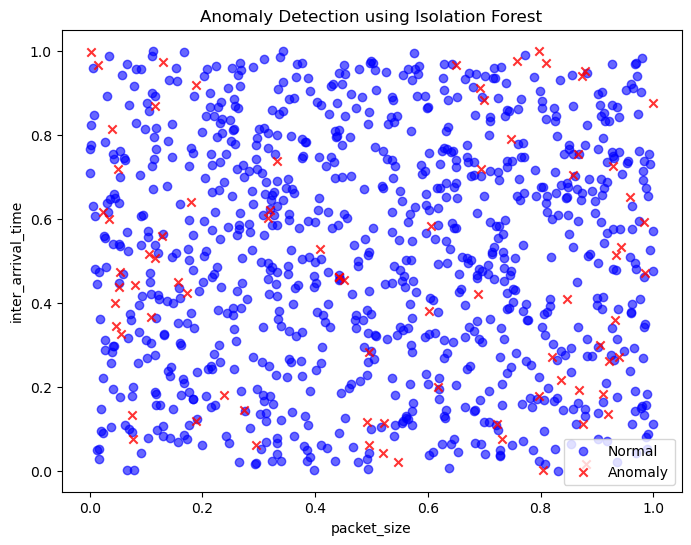

In [34]:
# Separate data
normal = features[features['anomaly'] == 1]
anomaly = features[features['anomaly'] == -1]

# Plot
plt.figure(figsize=(8,6))

plt.scatter(normal.iloc[:,0], normal.iloc[:,1],
            color='blue', label='Normal', alpha=0.6)

plt.scatter(anomaly.iloc[:,0], anomaly.iloc[:,1],
            color='red', label='Anomaly', alpha=0.8, marker='x')

plt.xlabel(features.columns[0])
plt.ylabel(features.columns[1])
plt.legend()

plt.title("Anomaly Detection using Isolation Forest")
plt.show()


In [35]:
df['anomaly'] = anomaly_labels
df.to_csv("anomaly_output.csv", index=False)


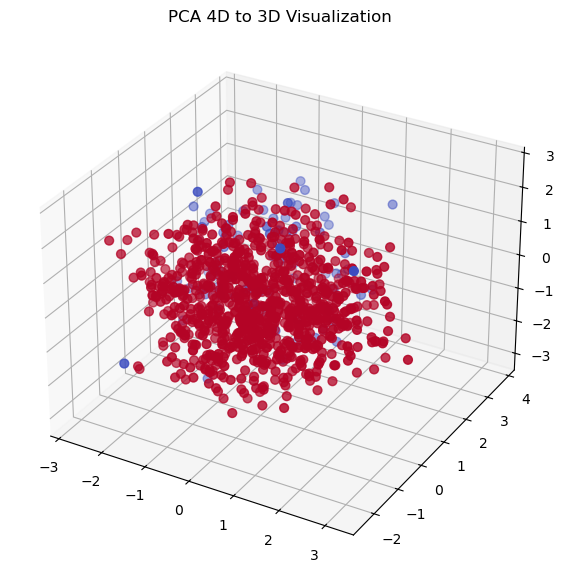

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    pca_result[:,0],
    pca_result[:,1],
    pca_result[:,2],
    c=features['anomaly'],
    cmap='coolwarm',
    s=40
)

ax.set_title("PCA 4D to 3D Visualization")
plt.show()


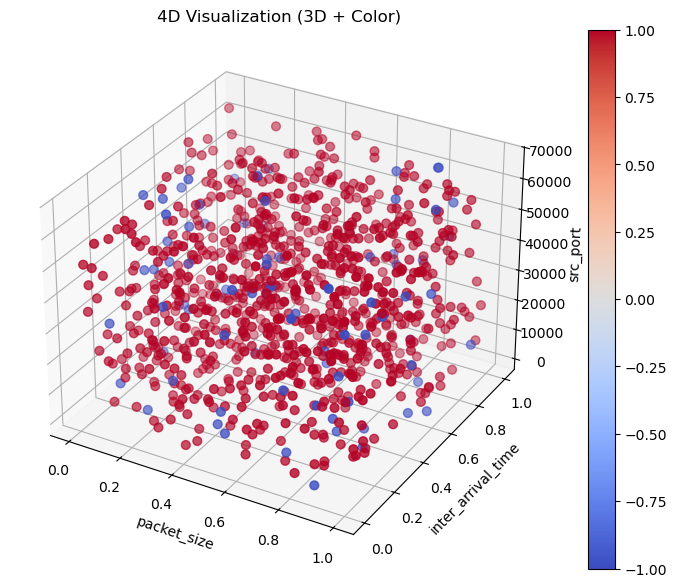

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Select first 4 features
cols = features.columns[:4]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    features[cols[0]],
    features[cols[1]],
    features[cols[2]],
    c=features['anomaly'],   # color based on anomaly
    cmap='coolwarm',
    s=40
)

ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.set_zlabel(cols[2])

plt.title("4D Visualization (3D + Color)")
plt.colorbar(scatter)
plt.show()
